# 07-03: Strength of Friendship Paradox in Random Networks

November 30th 2022

In the final practice session, we explore the analytical explanation of the friendship paradox given in lecture 05, and test resulting predictions about the strength of the friendship paradox in random networks with different degree distributions.

In [1]:
import pathpy as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")

### Analytical Explanation of the Friendship Paradox

Last week, we have considered the empirical network of character occurrences in The Lord of the Rings, which exhibits a strong friendship paradox.

In [2]:
n = pp.io.sql.read_network('../data/networks.db', sql='SELECT DISTINCT source, target FROM lotr',directed=False)
print(n)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> = ", k)
print("<k_n> = ", kn)
print("<k_n> - <k>", kn-k)

[11-30 13:32:15: WARNING] 67 edges existed already and were not be considered. To capture those edges, consider creating a multiedge and/or directed network.


Uid:			0x2e0f55a5760
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	139
Number of edges:	634
<k> =  9.122302158273381
<k_n> =  19.402208201892744
<k_n> - <k> 10.279906043619363


Using generating functions, we explained that the friendship paradox holds in random networks iff the degree distribution exhibits positive variance. We test this by generating a random network with the same degree sequence like the network above. For this, we can use the Molloy-Reed model implementation of `pathpy`, which allows us to create a random realization of a network with the same degree sequence:

In [3]:
n_rand = pp.generators.Molloy_Reed_randomize(n)
print(n_rand)
k = n_rand.mean_degree()
kn = n_rand.mean_neighbor_degree()
print("<k> = ", k)
print("<k_n> = ", kn)
print("<k_n> - <k>", kn-k)

Uid:			0x2e0f55f0b80
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	139
Number of edges:	634
<k> =  9.122302158273381
<k_n> =  19.402208201892744
<k_n> - <k> 10.279906043619363


We find that the strength of the friendship paradox is identical to the empirical network, thus confirming that it can be explained by the network's degree sequence. What if we generate a random Erdös-Renyi network with the same number of nodes and links?

In [9]:
n_rand = pp.generators.ER_nm_randomize(n)
print(n_rand)
k = n_rand.mean_degree()
kn = n_rand.mean_neighbor_degree()
print("<k> = ", k)
print("<k_n> = ", kn)
print("<k_n> - <k>", kn-k)

Uid:			0x2e0f58b52e0
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	139
Number of edges:	634
<k> =  9.122302158273381
<k_n> =  10.230283911671924
<k_n> - <k> 1.1079817533985423


We find that the difference between the mean neighbour degree and the mean degree is much smaller than in the empirical network. It is actually close to one, which is consistent with out analytical finding from the lecture. Hence, in Erdös-Renyi networks, if we do not account for the link (v,w) when calculating the degree of neighbours w of node v (i.e. if we consider the excess degree distribution rather than the neighbour degree distribution), we actually get the same distribution as if we were to consider the degrees of randomly chosen nodes. Let us test this: 

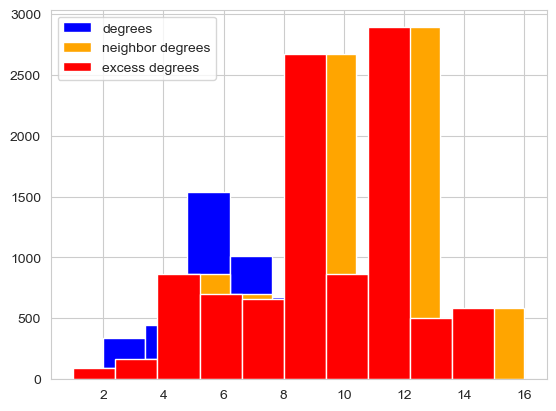

In [10]:
degrees = []
neighbor_degrees = []
excess_degrees = []
for i in range(10000):
     v = np.random.choice(list(n_rand.nodes.uids))
     degrees.append(n_rand.degrees()[v])
     if n_rand.degrees()[v]>0:
        w = np.random.choice(list(x.uid for x in n_rand.successors[v]))
        neighbor_degrees.append(n_rand.degrees()[w])
        excess_degrees.append(n_rand.degrees()[w] - 1)
plt.hist(degrees, color='blue', label='degrees')
plt.hist(neighbor_degrees, color='orange',  label='neighbor degrees')
plt.hist(excess_degrees, color='red', label='excess degrees')
plt.legend()

What differences between the mean degree and the mean neighbor degree do we expect in a network? We can use the analysis from the lecture to calculate this for any degree distribution, simply based on the first and second raw moment of the degree distribution.

For the expected neighbour degree we found: $\frac{\langle k^2 \rangle}{\langle k \rangle}$

For the difference to the mean degree we thus find:

$\frac{\langle k^2 \rangle}{\langle k \rangle} - \langle k \rangle = \frac{\langle k^2 \rangle - \langle k \rangle^2}{\langle k \rangle} = \frac{\sigma^2}{\langle k \rangle}$

where $\sigma^2$ is the variance of the degree distribution (remember the MOSSOM rule, i.e. variance is the mean of squares minus the square of means).

Hence, the strength of the friendship paradox depends on the ratio between variance and mean of the degree distribution, which in the Erdös-Renyi network is one because for a Poisson distribution the variance is equal to the mean! Let us test this in the empirical network:

In [11]:
k = n.mean_degree()
kn = n.mean_neighbor_degree()
degrees = n.degree_sequence()
print("<k> \t\t= ", k)
print("<k_n> \t\t= ", kn)
print("<k_n> - <k> \t= ", kn-k)
print("Var/Mean \t= ", np.var(degrees)/np.mean(degrees))

<k> 		=  9.122302158273381
<k_n> 		=  19.402208201892744
<k_n> - <k> 	=  10.279906043619363
Var/Mean 	=  10.279906043619363


Let us try this for random microstates from the statistical ensemble of Molloy-Reed networks with a different degree distribution:

In [12]:
degrees = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees):
    degrees = np.random.zipf(2.5, 300)
n = pp.generators.Molloy_Reed(degrees)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> \t\t= ", k)
print("<k_n> \t\t= ", kn)
print("<k_n> - <k> \t= ", kn-k)
print("Var/Mean \t= ", np.var(degrees)/np.mean(degrees))

<k> 		=  1.9666666666666666
<k_n> 		=  6.406779661016949
<k_n> - <k> 	=  4.440112994350282
Var/Mean 	=  4.440112994350282


For a Erdös-Renyi network, the variance of the degree distribution divided by the mean degree is actually one. Below we do not obtain a value of exactly one because we estimate the variance and mean of the distribution based on the degree sample rather than using the known expected value and variance from the underlying Poisson/Binomial distribution.

In [13]:
n = pp.generators.ER_np(n=1000, p=2/1000)
degrees = pp.statistics.degree_sequence(n)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> =\t\t", k)
print("<k_n> =\t\t", kn)
print("<k_n> - <k> =\t", kn-k)
print("Var/Mean =\t", np.var(degrees)/np.mean(degrees))

<k> =		 2.028
<k_n> =		 2.978303747534517
<k_n> - <k> =	 0.9503037475345169
Var/Mean =	 0.9503037475345166


This leads us to an interesting fact: We know that the limiting degree distribution of sparse Erdös-Renyi networks is a Poisson distribution where both the mean and the variance are $\lambda=np$. This approximation holds for large networks but what about small networks, which we know have a Binomial distribution with mean $np$ and variance $np(1-p)$. In this case, the term that determines the strength of the friendship paradox actually becomes:

$\frac{\langle k^2 \rangle}{\langle k \rangle} - \langle k \rangle = \frac{\sigma^2}{\langle k \rangle} = \frac{np(1-p)}{np} = 1-p \rightarrow 1 (p \rightarrow 0)$

For large sparse networks with fixed mean degree, the strength of the friendship paradox converges to one, since $p \rightarrow 0$ for $np \rightarrow \text{const}$. However, for sufficiently small networks and sufficiently large $p$, we should be able to see the discrepancy between the prediction derived from the Poisson approximation and the Binomial degree distribution. Let us try this:


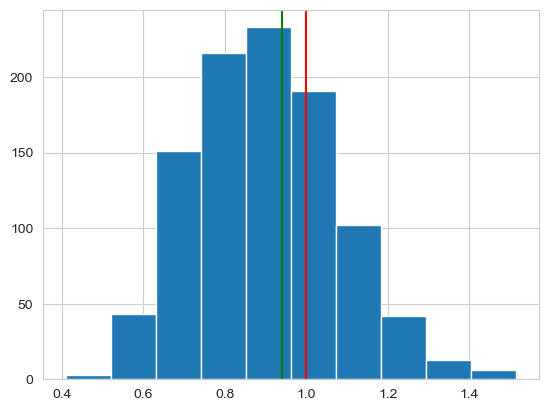

In [14]:
diffs = []

for i in range(1000):
    n = pp.generators.ER_np(n=50, p=3/50)
    k = n.mean_degree()
    kn = n.mean_neighbor_degree()
    diffs.append(kn-k)
plt.hist(diffs)
plt.axvline(1, color='red')
plt.axvline(1-(3/50), color='green')

Indeed, the center of the empirical distribution is slightly smaller than one (red line), which we would expect based on the Poisson approximation. This shift is however expected, as shown by the green line, which is the expected strength of the friendship paradox based on the Binomial distribution!

The Poisson distribution has only a single parameter and we cannot change the mean of the distribution without changing the variance proportionally. Hence, the strength of the friendship paradox is not affected by the mean degree:

In [15]:
n = pp.generators.ER_np(n=1000, p=7/1000)
degrees = pp.statistics.degree_sequence(n)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> =\t\t", k)
print("<k_n> =\t\t", kn)
print("<k_n> - <k> =\t", kn-k)
print("<k_n - k> =\t", 1)

<k> =		 6.946
<k_n> =		 7.980996256838468
<k_n> - <k> =	 1.0349962568384683
<k_n - k> =	 1


That is different for other degree distributions, e.g. for the Normal distribution, where we can control the mean and the variance separately.

In [20]:
degrees = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees):
    degrees = [int(x) for x in np.random.normal(3, 1, 300)]
n = pp.generators.Molloy_Reed(degrees)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> =\t\t", k)
print("<k_n> =\t\t", kn)
print("<k_n>-<k> =\t", kn-k)
print("<k_n - k> =\t", 1/3)

<k> =		 2.3933333333333335
<k_n> =		 2.8551532033426184
<k_n>-<k> =	 0.4618198700092848
<k_n - k> =	 0.3333333333333333


If we increase the mean degre while keeping the variance constant, we reduce the strength of the friendship paradox:

In [20]:
degrees = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees):
    degrees = [int(x) for x in np.random.normal(10, 1, 300)]
n = pp.generators.Molloy_Reed(degrees)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> =\t\t", k)
print("<k_n> =\t\t", kn)
print("<k_n>-<k> =\t", kn-k)
print("<k_n - k> =\t", 1/10)

<k> =		 9.5
<k_n> =		 9.616140350877194
<k_n>-<k> =	 0.11614035087719365
<k_n - k> =	 0.1


If we increase the variance while keeping the mean degree constant we increase the strength of the friendship paradox:

In [21]:
degrees = [1]
while not pp.generators.is_graphic_Erdos_Gallai(degrees):
    degrees = [int(x) for x in np.random.normal(10, 2, 300)]
n = pp.generators.Molloy_Reed(degrees)
k = n.mean_degree()
kn = n.mean_neighbor_degree()
print("<k> =\t\t", k)
print("<k_n> =\t\t", kn)
print("<k_n>-<k> =\t", kn-k)
print("<k_n - k> =\t", 4/10)

<k> =		 9.473333333333333
<k_n> =		 9.877551020408163
<k_n>-<k> =	 0.40421768707482997
<k_n - k> =	 0.4


In general, we can say that we expect networks with a small mean degree and a large variance in the degrees to exhibit a strong friendship paradox, which is consistent with the fact that we observe a strong friendship paradox in many social networks.